In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()

# Classifiers to select
toSelect = [('mood_acoustic', 'acoustic'), ('mood_electronic', 'electronic'),
            ('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]
# Labels used for these plots
labels = [x[0] for x in toSelect]

def plot_distribution(data, toSelect, labels, ytop):
    cols = [data[x] for x in toSelect]
    sns.set(font_scale=1)
    fig = plt.figure(figsize=(8,8))
    plt.ylim(top=ytop)
    plt.xlabel('Bin range')
    plt.ylabel('Bin count')

    for i in range(0, len(cols)):
        y,binEdges = np.histogram(cols[i],bins=200)
        bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
        plt.plot(bincenters, y, label=labels[i])

    plt.legend()
    plt.show()

# Load in the acousticbrainz dataset into the variable 'acousticbrainz'
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV3.h5')

acousticbrainz['mbid'] = acousticbrainz.index.get_level_values(0)

C:\Users\Chris\Miniconda3\envs\thesis2\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Spike in acousticness at 0.09 - 0.10
acoust_spike = acousticbrainz[acousticbrainz[('mood_acoustic', 'acoustic')].between(0.09, 0.10, inclusive=True)]

# Spike in mood relaxed at 0.805 - 0.815
relaxed_spike = acousticbrainz[acousticbrainz[('mood_relaxed', 'relaxed')].between(0.805, 0.815, inclusive=True)]

# Spike in mood electronic at 0.972 - 0.982
electronic_spike = acousticbrainz[acousticbrainz[('mood_electronic', 'electronic')].between(0.972, 0.982, inclusive=True)]

# Small spike in sad at 0.346 - 0.362
sad_spike = acousticbrainz[acousticbrainz[('mood_sad', 'sad')].between(0.346, 0.362, inclusive=True)]

In [3]:
spike_names = ['acoust_spike', 'relaxed_spike', 'electronic_spike', 'sad_spike']
recordingsizes = pd.DataFrame(
    [len(acoust_spike.index.get_level_values(0).unique()),
    len(relaxed_spike.index.get_level_values(0).unique()),
    len(electronic_spike.index.get_level_values(0).unique()),
    len(sad_spike.index.get_level_values(0).unique())],
    index=spike_names, columns=['#recordings']
)
samplesizes = pd.DataFrame([len(acoust_spike), len(relaxed_spike), len(electronic_spike), len(sad_spike)], index=spike_names, columns=['#submissions'])

samplesizes = recordingsizes.join(samplesizes)
samplesizes

,#recordings,#submissions
acoust_spike,282605,358747
relaxed_spike,373555,485184
electronic_spike,315626,401151
sad_spike,57697,75688


In [4]:
samplesizes.to_latex()

'\\begin{tabular}{lrr}\n\\toprule\n{} &  \\#recordings &  \\#submissions \\\\\n\\midrule\nacoust\\_spike     &       282605 &        358747 \\\\\nrelaxed\\_spike    &       373555 &        485184 \\\\\nelectronic\\_spike &       315626 &        401151 \\\\\nsad\\_spike        &        57697 &         75688 \\\\\n\\bottomrule\n\\end{tabular}\n'

The baseline consists of all submissions that do **not** fall in *any* of these three peaks:

In [5]:
spike_ids = set(acoust_spike.index).union(relaxed_spike.index, electronic_spike.index, sad_spike.index)
nonspike_ids = set(acousticbrainz.index).difference(spike_ids)
baseline = acousticbrainz.loc[list(nonspike_ids)]

Make sure that the baseline has the peaks filtered out:

Full dataset:


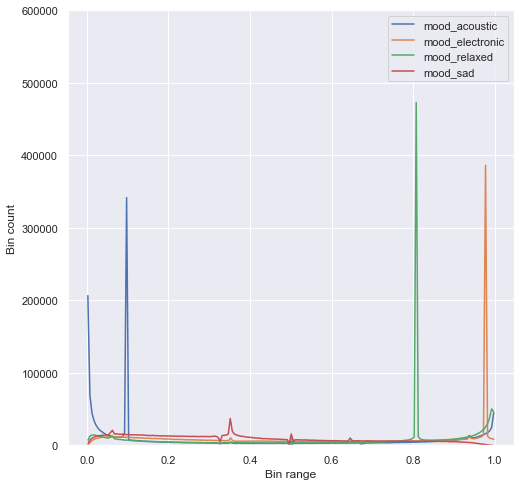

Baseline:


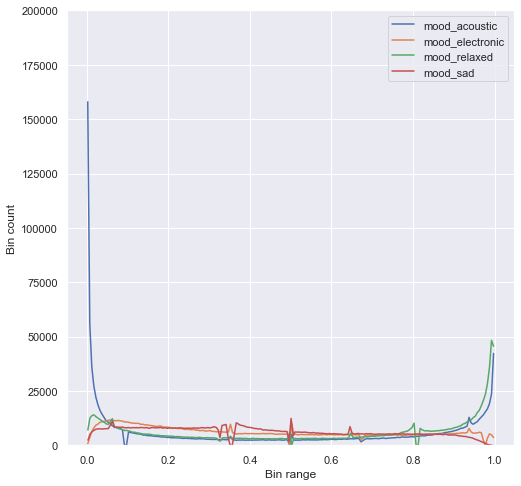

No. recordings: 855266
No. submissions: 1239882


In [6]:
print("Full dataset:")
plot_distribution(acousticbrainz, toSelect, labels, 600000)
print("Baseline:")
plot_distribution(baseline, toSelect, labels, 200000)
print(f"No. recordings: {len(baseline.index.get_level_values(0).unique())}")
print(f"No. submissions: {len(baseline)}")

So the full samplesizes for all slices are:

In [7]:
samplesizes.loc['baseline'] = len(baseline)
samplesizes

,#recordings,#submissions
acoust_spike,282605,358747
relaxed_spike,373555,485184
electronic_spike,315626,401151
sad_spike,57697,75688
baseline,1239882,1239882


# Simple analysis

In [8]:
# Check if any pattern in the amount of lossless songs:
loss_baseline = baseline['lossless'].value_counts(normalize=True)
loss_acoust_spike = acoust_spike['lossless'].value_counts(normalize=True)
loss_relaxed_spike = relaxed_spike['lossless'].value_counts(normalize=True)
loss_electronic_spike = electronic_spike['lossless'].value_counts(normalize=True)
loss_sad_spike = sad_spike['lossless'].value_counts(normalize=True)

lossless_stats = pd.DataFrame([loss_baseline[1], loss_acoust_spike[1], loss_relaxed_spike[1],
                               loss_electronic_spike[1], loss_sad_spike[1]],
            index=['Baseline', 'Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Sad spike'],
            columns = ['Percentage lossless'])

display(lossless_stats)
print(lossless_stats.to_latex())

# Check if any pattern in the codec of the songs:
codec_baseline = baseline['codec'].value_counts(normalize=True)
codec_acoust_spike = acoust_spike['codec'].value_counts(normalize=True)
codec_relaxed_spike = relaxed_spike['codec'].value_counts(normalize=True)
codec_electronic_spike = electronic_spike['codec'].value_counts(normalize=True)
codec_sad_spike = sad_spike['codec'].value_counts(normalize=True)

codec_stats = pd.DataFrame([codec_baseline, codec_acoust_spike, codec_relaxed_spike,
                               codec_electronic_spike, codec_sad_spike],
            index=['Baseline', 'Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Sad spike'],)

display(codec_stats)
print(codec_stats[['mp3', 'flac', 'vorbis', 'aac', 'alac']].fillna(value=0.0).to_latex())

# Most versions are the same, however the essentia version for the low level features
# (used to calculate the high level features) does have some variation
ver_baseline = baseline['essentia_low'].value_counts(normalize=True)
ver_acoust_spike = acoust_spike['essentia_low'].value_counts(normalize=True)
ver_relaxed_spike = relaxed_spike['essentia_low'].value_counts(normalize=True)
ver_electronic_spike = electronic_spike['essentia_low'].value_counts(normalize=True)
ver_sad_spike = sad_spike['essentia_low'].value_counts(normalize=True)

ver_stats = pd.DataFrame([ver_baseline, ver_acoust_spike, ver_relaxed_spike,
                          ver_electronic_spike, ver_sad_spike],
                        index=['Baseline', 'Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Sad spike'])

display(ver_stats)
print(ver_stats.to_latex())

,Percentage lossless
Baseline,0.383775
Acoustic spike,0.105501
Relaxed spike,0.162542
Electronic spike,0.117786
Sad spike,0.364800


\begin{tabular}{lr}
\toprule
{} &  Percentage lossless \\
\midrule
Baseline         &             0.383775 \\
Acoustic spike   &             0.105501 \\
Relaxed spike    &             0.162542 \\
Electronic spike &             0.117786 \\
Sad spike        &             0.364800 \\
\bottomrule
\end{tabular}



,mp3,flac,vorbis,aac,wmav2,alac,mpc7,mp2,ape,wavpack,mp1,wmapro,mpc8
Baseline,0.531555,0.382918,0.042965,0.040064,0.001094,0.000760,0.000408,0.000101,0.000098,0.000034,0.000002,8.065284e-07,8.065284e-07
Acoustic spike,0.844213,0.083374,0.028633,0.017084,0.004125,0.022121,0.000137,0.000089,0.000006,0.000195,NaN,NaN,2.229984e-05
Relaxed spike,0.783913,0.144755,0.031341,0.018086,0.003685,0.017748,0.000165,0.000091,0.000039,0.000159,NaN,NaN,1.854966e-05
Electronic spike,0.832754,0.097053,0.029009,0.016009,0.004023,0.020728,0.000110,0.000095,0.000005,0.000192,NaN,NaN,2.243544e-05
Sad spike,0.570315,0.361550,0.032647,0.027785,0.003686,0.003250,0.000370,0.000119,NaN,0.000277,NaN,NaN,NaN


\begin{tabular}{lrrrrr}
\toprule
{} &       mp3 &      flac &    vorbis &       aac &      alac \\
\midrule
Baseline         &  0.531555 &  0.382918 &  0.042965 &  0.040064 &  0.000760 \\
Acoustic spike   &  0.844213 &  0.083374 &  0.028633 &  0.017084 &  0.022121 \\
Relaxed spike    &  0.783913 &  0.144755 &  0.031341 &  0.018086 &  0.017748 \\
Electronic spike &  0.832754 &  0.097053 &  0.029009 &  0.016009 &  0.020728 \\
Sad spike        &  0.570315 &  0.361550 &  0.032647 &  0.027785 &  0.003250 \\
\bottomrule
\end{tabular}



,2.1-beta2,2.1-beta1
Baseline,0.791706,0.208294
Acoustic spike,0.112207,0.887793
Relaxed spike,0.197968,0.802032
Electronic spike,0.125277,0.874723
Sad spike,0.637921,0.362079


\begin{tabular}{lrr}
\toprule
{} &  2.1-beta2 &  2.1-beta1 \\
\midrule
Baseline         &   0.791706 &   0.208294 \\
Acoustic spike   &   0.112207 &   0.887793 \\
Relaxed spike    &   0.197968 &   0.802032 \\
Electronic spike &   0.125277 &   0.874723 \\
Sad spike        &   0.637921 &   0.362079 \\
\bottomrule
\end{tabular}



# JSD analysis

In [9]:
from scipy.spatial.distance import jensenshannon

# Input should be value counts
def get_shannondist(a, b):
    # Make sure that the value occurs a few times (10 was chosen here) to prevent inflation due to rare or invalid values
    a = a[a >= 10]
    b = b[b >= 10]
    # Make a dataframe to sort the indexes and drop values that do not occur in both inputs
    df = pd.DataFrame([a,b]).dropna(axis=1)
    # Return the distance
    return jensenshannon(df.iloc[0], df.iloc[1], base=2)

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [10]:
#spikes_list = [baseline, acoust_spike, relaxed_spike, electronic_spike, sad_spike]
#spikes_list_names = ['baseline'] + spike_names

spikes_list = [acoust_spike, relaxed_spike, electronic_spike, sad_spike]
variables = ['analysis_sample_rate', 'bit_rate', 'codec', 'downmix', 'equal_loudness', 'length', 'lossless',
            'replay_gain', 'essentia_high', 'extractor_high', 'gaia_high', 'essentia_low', 'essentia_git_sha_low',
            'essentia_build_sha_low', 'extractor_low']

# Dataframe to save results
res = pd.DataFrame(columns=spike_names, index=variables)

# For each spike, for each variable, compute JSD between peak and baseline
for i in range(0, len(spikes_list)):
    # a contains all submissions that fall within the bounds of the spike
    a = spikes_list[i]
        
    # b contains all submissions that are NOT within the bounds of the spike, i.e. (full dataset)-(spike)
    #idx_diff = list(set(acousticbrainz.index).difference(set(a.index)))
    #b = acousticbrainz.loc[idx_diff]
    
    b = baseline
    
    for var in variables:

        # Calculate distance
        dist = get_shannondist(a[var].value_counts(), b[var].value_counts())

        # Set distance in the result dataframe
        res.loc[var][spike_names[i]] = dist

res = res.loc[~(res==0).all(axis=1)]
res.sort_values(by='acoust_spike')

,acoust_spike,relaxed_spike,electronic_spike,sad_spike
downmix,0.000893558,0.000526145,0.000697558,0
length,0.145746,0.150273,0.148331,0.31763
lossless,0.281495,0.21319,0.265893,0.0166514
codec,0.339619,0.26285,0.322216,0.0569593
bit_rate,0.418759,0.322867,0.39447,0.166321
essentia_low,0.609062,0.521436,0.594767,0.145326
essentia_git_sha_low,0.672409,0.584972,0.660398,0.23105
essentia_build_sha_low,0.70419,0.615245,0.692346,0.239792


In [11]:
print(res.to_latex())

\begin{tabular}{lllll}
\toprule
{} & acoust\_spike & relaxed\_spike & electronic\_spike &  sad\_spike \\
\midrule
bit\_rate               &     0.418759 &      0.322867 &          0.39447 &   0.166321 \\
codec                  &     0.339619 &       0.26285 &         0.322216 &  0.0569593 \\
downmix                &  0.000893558 &   0.000526145 &      0.000697558 &          0 \\
length                 &     0.145746 &      0.150273 &         0.148331 &    0.31763 \\
lossless               &     0.281495 &       0.21319 &         0.265893 &  0.0166514 \\
essentia\_low           &     0.609062 &      0.521436 &         0.594767 &   0.145326 \\
essentia\_git\_sha\_low   &     0.672409 &      0.584972 &         0.660398 &    0.23105 \\
essentia\_build\_sha\_low &      0.70419 &      0.615245 &         0.692346 &   0.239792 \\
\bottomrule
\end{tabular}



In [12]:
print('Average across all peaks:')
res.mean(axis=1).sort_values()

Average across all peaks:


downmix                   0.000529
length                    0.190495
lossless                  0.194307
codec                     0.245411
bit_rate                  0.325604
essentia_low              0.467648
essentia_git_sha_low      0.537207
essentia_build_sha_low    0.562893
dtype: float64

# Genre sanity check

Intersection three genre datasets and acousticbrainz:


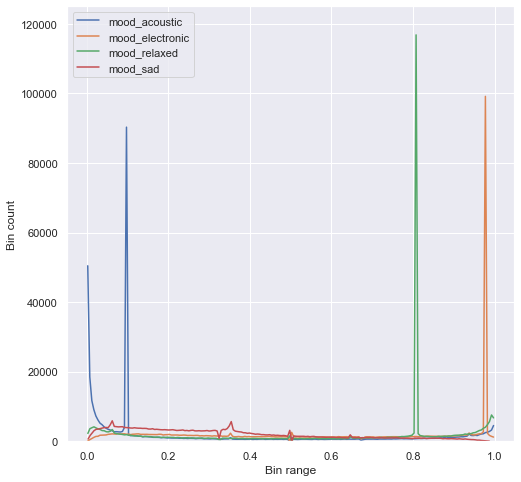

Amount of recordings (MBIDs): 164826
Amount of submissions: 402279


In [13]:
# We only look at the main genre present in the genre dataset (i.e. rock, pop, classical etc... no subgenres)
genre_cols = ['recordingmbid', 'genre1']

# We have three 'ground truth sources' for genre: discogs, lastfm and tagtraum
discogs = pd.read_csv(Path.cwd() / 'datasets' / 'acousticbrainz_genres' / 'acousticbrainz-mediaeval2017-discogs-train.tsv',
                     sep='\t', usecols=genre_cols)
lastfm = pd.read_csv(Path.cwd() / 'datasets' / 'acousticbrainz_genres' / 'acousticbrainz-mediaeval2017-lastfm-train.tsv', 
                     sep='\t', usecols=genre_cols)
tagtraum = pd.read_csv(Path.cwd() / 'datasets' / 'acousticbrainz_genres' / 'acousticbrainz-mediaeval2017-tagtraum-train.tsv', 
                     sep='\t', usecols=genre_cols)

# Check which MBIDs are contained in all three datasets
discogs_ids = set(discogs['recordingmbid'])
lastfm_ids = set(lastfm['recordingmbid'])
tagtraum_ids = set(tagtraum['recordingmbid'])
genre_ids = discogs_ids.intersection(lastfm_ids, tagtraum_ids)

# Only look at acousticbrainz data for which a genre is available in all three genre datasets
genre_filtered = acousticbrainz[acousticbrainz.index.get_level_values(0).isin(list(genre_ids), level=0)]

# Check distribution
# Make the plot
print("Intersection three genre datasets and acousticbrainz:")
plot_distribution(genre_filtered, toSelect, labels, 125000)

# Size stats
print(f"Amount of recordings (MBIDs): {len(list(genre_filtered.index.get_level_values(0).unique()))}")
print(f"Amount of submissions: {len(genre_filtered)}")

In [14]:
# Merge the three genre sets
discogs.columns = ['mbid', 'discogs']
lastfm.columns = ['mbid', 'lastfm']
tagtraum.columns = ['mbid', 'tagtraum']
discogs.set_index('mbid')
lastfm.set_index('mbid')
tagtraum.set_index('mbid')

genre_data = discogs.merge(lastfm).merge(tagtraum)
genre_data = genre_data[genre_data['mbid'].isin(acousticbrainz.index.get_level_values(0))]

genre_data

,mbid,discogs,lastfm,tagtraum
0,8eed6eed-24e7-4ac9-98dd-2e20502c1b13,rock,rock,rock/pop
1,a05966c4-aaf8-4508-ba23-3193b5067fc0,electronic,reggae,electronic
2,1a00a335-fead-46ec-8d4f-06e8341291ea,electronic,electronic,dance
4,1f5cc450-7ed3-4329-9f47-2a97b8cbd58a,electronic,jazz,electronic
6,fd081a38-5bb3-43aa-94c5-d50743ec23cf,rock,rock,rock/pop
...,...,...,...,...
255850,185cb993-4a79-4cad-bf5c-d6a4a2b3778f,rock,metal,rock/pop
255851,02e1860b-f550-41ec-ba12-1f679329c439,rock,rock,rock/pop
255852,492848a7-249c-4dfc-93e3-621a7b1e1043,"folk, world, & country",folk,comedy
255853,bb84e699-d478-4fe7-af18-9aa73a839ff7,rock,rock,rock/pop


Intersection three genre datasets and acousticbrainz, baseline:


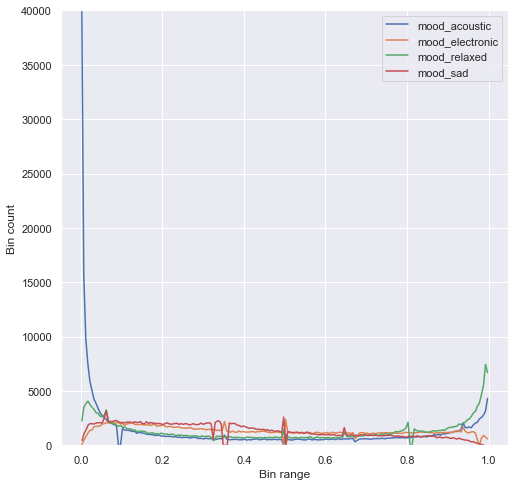

Amount of recordings (MBIDs): 128687
Amount of submissions: 267394


In [15]:
# Construct baseline (acousticbrainz data for which all three genres are available that does NOT fall in any of the three peaks)
genre_baseline = genre_filtered[genre_filtered.index.isin(list(nonspike_ids))]

# Make sure peaks are filtered out
# Make the plot
print("Intersection three genre datasets and acousticbrainz, baseline:")
plot_distribution(genre_baseline, toSelect, labels, 40000)

# Size stats
print(f"Amount of recordings (MBIDs): {len(list(genre_baseline.index.get_level_values(0).unique()))}")
print(f"Amount of submissions: {len(genre_baseline)}")
    

In [16]:
# Three peaks now also only contain data for which three genre labels were available
genre_acoust_spike = acoust_spike[acoust_spike.index.get_level_values(0).isin(list(genre_ids))]
genre_relaxed_spike = relaxed_spike[relaxed_spike.index.get_level_values(0).isin(list(genre_ids))]
genre_electronic_spike = electronic_spike[electronic_spike.index.get_level_values(0).isin(list(genre_ids))]
genre_sad_spike = sad_spike[sad_spike.index.get_level_values(0).isin(list(genre_ids))]

In [17]:
genre_spike_names = ['genre_acoust_spike', 'genre_relaxed_spike', 'genre_electronic_spike', 'genre_sad_spike']
genre_spikes = [genre_acoust_spike, genre_relaxed_spike, genre_electronic_spike, genre_sad_spike]

recordingsizes = pd.DataFrame(
    [len(genre_acoust_spike.index.get_level_values(0).unique()),
    len(genre_relaxed_spike.index.get_level_values(0).unique()),
    len(genre_electronic_spike.index.get_level_values(0).unique()),
    len(genre_sad_spike.index.get_level_values(0).unique())],
    index=genre_spike_names, columns=['#recordings']
)

# Spikes still contain submissions, multiple submissions for mbid might fall in different spikes but since we only have 
# genre ground truth at the mbid level, we look at which mbids fall in the peak (might be several)
recordingsizes

,#recordings
genre_acoust_spike,60261
genre_relaxed_spike,72739
genre_electronic_spike,64944
genre_sad_spike,8854


In [18]:
# Now we can calculate JSD against the baseline for the genres
sources = ['discogs', 'lastfm', 'tagtraum']

# genre data for baseline
baseline_genre_data = genre_data[genre_data['mbid'].isin(genre_baseline.index.get_level_values(0).unique())]

# Resulting dataframe
genre_jsd_res = pd.DataFrame(columns=sources, index=genre_spike_names)

for i in range(0, len(genre_spikes)):
    # Which mbids are in this spike?
    spike_mbids = genre_spikes[i].index.get_level_values(0).unique()
    
    # Fetch genre data for these mbids
    spike_genre_data = genre_data[genre_data['mbid'].isin(spike_mbids)]
    
    # Check all three sources
    for source in sources:
        dist = get_shannondist(spike_genre_data[source].value_counts(), baseline_genre_data[source].value_counts())
        genre_jsd_res.loc[genre_spike_names[i]][source] = dist
        
genre_jsd_res

,discogs,lastfm,tagtraum
genre_acoust_spike,0.121217,0.141714,0.138084
genre_relaxed_spike,0.0943394,0.116578,0.114325
genre_electronic_spike,0.112098,0.134499,0.130844
genre_sad_spike,0.108356,0.144426,0.135816
